## Transversal Error Corrected After Every Gate Qubit Adder

In [5]:
%load_ext autoreload
%autoreload 2

import qiskit
import helpers.common as common
import helpers.gates as gates
import helpers.constants as constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Create quantum registers
creq = []
areq = []
breq = []
for i in range(constants.bits):
    creq.append(common.logical_register(f"c{i}"))
    areq.append(common.logical_register(f"a{i}"))
    breq.append(common.logical_register(f"b{i}"))
breq.append(common.logical_register(f"b{constants.bits}"))


# Combine quantum registers into a single list
req_cat = []
for i in range(constants.bits):
    req_cat.extend(creq[i])
    req_cat.extend(areq[i])
    req_cat.extend(breq[i])
req_cat.extend(breq[constants.bits])

classical_req = qiskit.ClassicalRegister(constants.bits + 1, "result")
qc = qiskit.QuantumCircuit(*req_cat, classical_req)

# Add shor setup
for i in range(constants.bits):
    qc = gates.add_shor_setup(qc, creq[i])
    qc = gates.add_shor_setup(qc, areq[i])
    qc = gates.add_shor_setup(qc, breq[i])
qc = gates.add_shor_setup(qc, breq[constants.bits])

# Add X gates to set the initial values
for i in range(constants.bits):
    if constants.a[::-1][i] == "1":
        qc = gates.add_z(qc, areq[i])
        qc = gates.add_shor_teardown(qc, areq[i])
    if constants.b[::-1][i] == "1":
        qc = gates.add_z(qc, breq[i])
        qc = gates.add_shor_teardown(qc, breq[i])


# Add the carry and sum gates
for i in range(constants.bits):
    if i != constants.bits - 1:
        qc = gates.add_transversal_carry(qc, creq[i], areq[i], breq[i], creq[i + 1])

        qc = gates.add_shor_teardown(qc, creq[i])
        qc = gates.add_shor_teardown(qc, areq[i])
        qc = gates.add_shor_teardown(qc, breq[i])
        qc = gates.add_shor_teardown(qc, creq[i + 1])
    else:
        
        qc = gates.add_transversal_carry(qc, creq[i], areq[i], breq[i], breq[i + 1])
        qc = gates.add_cx(qc, breq[i], areq[i])

        qc = gates.add_shor_teardown(qc, creq[i])
        qc = gates.add_shor_teardown(qc, areq[i])
        qc = gates.add_shor_teardown(qc, breq[i])
        qc = gates.add_shor_teardown(qc, breq[i + 1])

for i in reversed(range(constants.bits)):
    qc = gates.add_transversal_sum(qc, creq[i], areq[i], breq[i])

    qc = gates.add_shor_teardown(qc, creq[i])
    qc = gates.add_shor_teardown(qc, areq[i])
    qc = gates.add_shor_teardown(qc, breq[i])

    if i != 0:
        qc = gates.add_transversal_reverse_carry(qc, creq[i - 1], areq[i - 1], breq[i - 1], creq[i])

        qc = gates.add_shor_teardown(qc, creq[i - 1])
        qc = gates.add_shor_teardown(qc, areq[i - 1])
        qc = gates.add_shor_teardown(qc, breq[i - 1])
        qc = gates.add_shor_teardown(qc, creq[i])

print(f"{qc.num_qubits} qubits used")

for i in range(constants.bits + 1):
    qc.measure(breq[i][0], classical_req[i])

qc.draw("mpl", fold=300, scale=2)

117 qubits used


Backend: ibm_brisbane
Most likely state: 00000


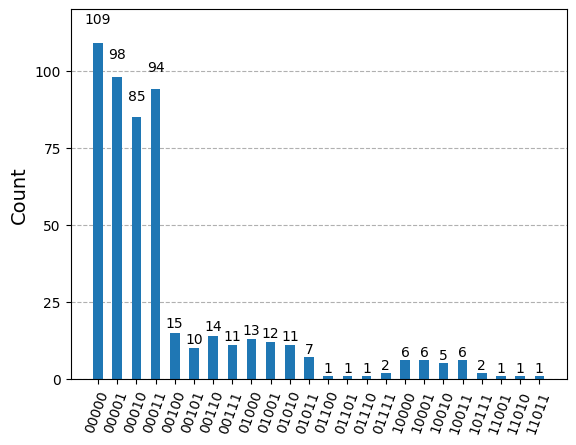

In [14]:
# raise common.StopExecution

simulator_cat = common.RealQuantumComputer(qc, 512)
counts_cat = simulator_cat.run("result")

print(f"Backend: {simulator_cat.backend_name()}")
print(f"Most likely state: {simulator_cat.most_common()}")

simulator_cat.plot()